In [105]:
import re
import random
import pandas as pd
import hashlib

In [ ]:
with open('certcards2.txt', mode='r', encoding='utf8') as f:
    all_cards = f.read()
    
card_split_pattern = r'\n\n\n\d+\n'
all_cards = re.split(card_split_pattern, all_cards)
# Use re.DOTALL to allow . to match newline characters
card_pattern = re.compile(r'(.+?)\n([\s\S]+)', re.DOTALL)
cards = [(match.group(1), match.group(2)) for cstring in all_cards if (match := re.search(card_pattern, cstring))]

# removing the cards that have no content and trimming
cards = [(subject, stripped_content) for subject, content in cards if len(stripped_content := content.strip()) > 5]

def hash_string_md5(s):
    """
    Hashes a string using MD5 and returns a truncated hash for efficiency.

    Parameters:
    - s (str): The input string to hash.

    Returns:
    - str: The truncated hexadecimal hash string.
    """
    if pd.isnull(s):
        return None  # Handle NaN values gracefully
    return hashlib.md5(s.encode('utf-8')).hexdigest()


def remake_card_document(existing_cards: pd.DataFrame, filename: str='certcards2.txt'):
    with open(filename, mode='w', encoding='utf8') as f:
        i = 1
        for _, row in existing_cards.iterrows():
            f.write('\n'*6)
            f.write(str(i)+'\n')  
            f.write(row['head']+'\n')
            f.write(row['body'])
            i+=1
    print(F"Cards found: {existing_cards.shape[0]}")
    print(F"Total card age: {abs(existing_cards['age'].sum()):.2f}")


existing_cards = pd.DataFrame(cards, columns=['head', 'body'])


# existing_cards['age'] = [random.random() for _ in existing_cards.index]
existing_cards['hash'] = existing_cards['body'].apply(hash_string_md5)
existing_cards

card_ages = pd.read_json('card_ages.json')
card_ages = card_ages.drop_duplicates(subset=['hash'], keep='first')

cards_to_age = pd.merge(
    left=existing_cards,
    right=card_ages[['hash', 'age']],
    left_on='hash', right_on='hash',
    how='left'
)

cards_to_age['head'] = cards_to_age['head'].str.strip()

# if cards_to_age['age'].mean() > 80: age_factor = .5
# else: age_factor = 1

cards_to_age['age'] = cards_to_age['age'].fillna(0)
# cards_to_age['age'] = cards_to_age['age'] * age_factor
cards_to_age['age'] = cards_to_age['age'] + [random.expovariate(.60) for _ in cards_to_age.index]
# cards_to_age['age'] = cards_to_age['age'] * [random.expovariate(1) for _ in cards_to_age.index]
if cards_to_age['age'].mean() > 80: 
    cards_to_age['age'] = cards_to_age['age'] * [random.expovariate(1.5) for _ in cards_to_age.index]

# Adding priority age growth to cards for upcoming certifications
priority_headers = ['Azure Developer Associate', 'Jane Eyre, Bronte']
priority_cards_mask = cards_to_age['head'].isin(priority_headers)
cards_to_age.loc[priority_cards_mask, 'age'] = cards_to_age.loc[priority_cards_mask, 'age'] * 1.05

cards_to_age = cards_to_age.drop_duplicates(subset=['hash'], keep='first')

cards_to_age['subject_mean_age'] = cards_to_age.groupby('head')['age'].transform('mean')
cards_to_age['subject_highest_age'] = cards_to_age.groupby('head')['age'].transform('max')
cards_to_age['subject_age_sum'] = cards_to_age.groupby('head')['age'].transform('sum')
cards_to_age['head_random_roll'] = cards_to_age.groupby('head')['head'].transform(lambda x: random.random())


cards_to_age.sort_values('hash')[['age', 'head', 'hash']].to_json('card_ages.json', indent=2)

existing_cards = cards_to_age

In [107]:
stats = existing_cards.groupby('head').agg({'age': ['sum', 'mean', 'max'], 'head': 'count'}).sort_values(('age', 'sum'))
stats.columns = stats.columns.to_flat_index()
stats.columns = ['_'.join(col).strip() for col in stats.columns]
stats.index.name = None
stats

,age_sum,age_mean,age_max,head_count
DAX,177.487450,19.720828,28.014690,9
Email Auth and Security,265.917955,66.479489,89.123647,4
RAG Project,523.176384,87.196064,135.183258,6
"Jane Eyre, Bronte",565.388144,70.673518,106.978576,8
Azure VM + Developer,856.630916,25.195027,37.838918,34
Azure AD Authentication,972.091029,81.007586,159.442374,12
TSQL,1016.540487,42.355854,59.794788,24
Logging in Python,1163.995167,83.142512,126.968931,14
Terraform,1684.501569,93.583420,155.298272,18
Azure Private DNS,1774.829666,93.412088,172.106764,19


# Histogram

sum of ages: ~53940.40


<Axes: >

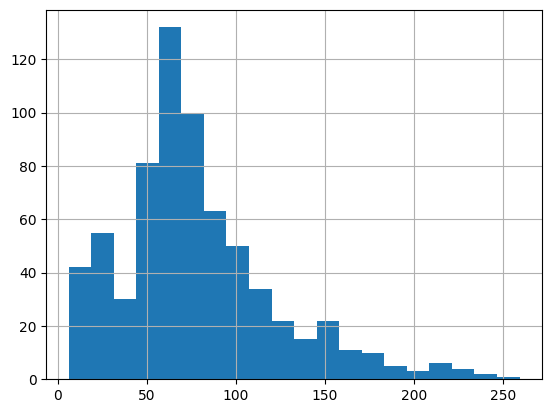

In [108]:
print(f"sum of ages: ~{existing_cards['age'].sum(0):.2f}")
existing_cards['age'].hist(bins=20)

sum of ages: ~53940.40


<Axes: >

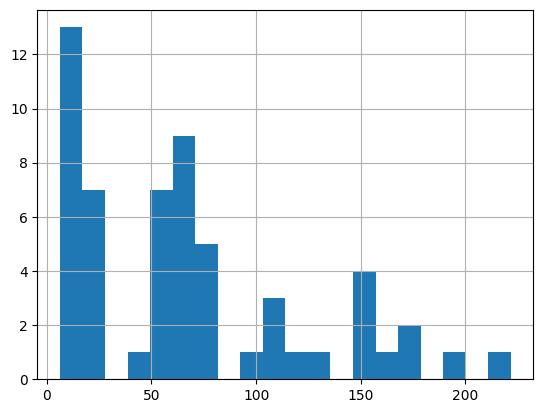

In [109]:
print(f"sum of ages: ~{existing_cards['age'].sum(0):.2f}")
existing_cards[existing_cards['head']=='Azure Developer Associate']['age'].hist(bins=20)

# Completely Random Shuffle

In [110]:
# existing_cards = existing_cards.sample(frac=1)
# remake_card_document(filename='certcards2.txt', existing_cards = existing_cards)

# Age Sort

In [111]:
# existing_cards = existing_cards.sort_values('age', ascending=False)
# remake_card_document(filename='certcards2.txt', existing_cards=existing_cards)
# existing_cards.head(10)

# Headers with fewest notes first

In [112]:
# frequency = existing_cards['head'].value_counts(ascending=True)

# existing_cards = pd.merge(
#     left=existing_cards,
#     right=frequency.rename('frequency'),
#     left_on='head', right_index=True,
#     how='left'
# )
# existing_cards['oldest'] = existing_cards.groupby('head')['age'].transform('max')
# existing_cards['subject_highest_age'] = existing_cards['subject_highest_age'] * -1
# existing_cards['age'] = existing_cards['age'] * -1


# existing_cards.sort_values(['frequency', 'subject_highest_age', 'age'], ascending=True, inplace=True)

# remake_card_document(filename='certcards2.txt', existing_cards=existing_cards)

# existing_cards.head(10)

## Headers with greatest age sum first

In [113]:
# existing_cards.sort_values(['subject_age_sum', 'age'], ascending=False, inplace=True)
# remake_card_document(existing_cards)
# existing_cards.head(10)

## Header with oldest cards first

In [114]:
# existing_cards['oldest'] = existing_cards.groupby('head')['age'].transform('max')
# existing_cards.sort_values(['oldest', 'age'], ascending=False, inplace=True)
# remake_card_document(existing_cards)

# Focus on one header

In [115]:
# heads = existing_cards['head'].value_counts()
# heads = heads[heads > 5].index.tolist()
# one_header = random.sample(heads, 1)[0]
# existing_cards['pick_head'] = existing_cards['head'].apply(
#     lambda h: 0 if h == one_header else 1 
# )

# remake_card_document(existing_cards=existing_cards.sort_values('pick_head'))

## Headers with greatest mean card age first

In [116]:
# existing_cards.sort_values(['subject_mean_age', 'age'], ascending=False, inplace=True)
# remake_card_document(existing_cards)

# N-fold shuffle


## Age Sum

In [117]:
# n=3
# m=existing_cards.shape[0]//100
# existing_cards['count'] = existing_cards.sort_values('age', ascending=False).groupby('head').cumcount()
# existing_cards['n_fold'] = existing_cards['count'] % n

# existing_cards['subject_age_sum'] = existing_cards['subject_age_sum'] *-1
# existing_cards['age'] = existing_cards['age'] *-1
# existing_cards.sort_values(['n_fold', 'subject_age_sum', 'age'], inplace=True)

# remake_card_document(existing_cards=existing_cards)
# existing_cards.head(10)


## Age Mean

In [118]:
# n=3
# existing_cards['count'] = existing_cards.sort_values('age', ascending=False).groupby('head').cumcount()
# existing_cards['n_fold'] = existing_cards['count'] % n

# existing_cards['subject_mean_age'] = existing_cards['subject_mean_age'] *-1
# existing_cards['age'] = existing_cards['age'] *-1
# existing_cards.sort_values(['n_fold', 'subject_mean_age', 'age'], inplace=True)
# remake_card_document(existing_cards=existing_cards)

# existing_cards.head(10)

## Age Max

In [119]:
# n = 3
# existing_cards['count'] = existing_cards.sort_values('age', ascending=False).groupby('head').cumcount()
# existing_cards['n_fold'] = existing_cards['count'] % n

# if existing_cards['age'].sum() > 0:
#     existing_cards['subject_highest_age'] = existing_cards['subject_highest_age'] *-1
#     existing_cards['neg_age'] = existing_cards['age'] *-1
# existing_cards.sort_values(['n_fold', 'subject_highest_age', 'neg_age'], inplace=True)
# # existing_cards.sort_values(['age'], inplace=True)

# remake_card_document(existing_cards=existing_cards)
# existing_cards.head(10)


## Card Count

In [120]:
n=5
existing_cards['frequency']  = existing_cards.groupby('head').transform('count')['body']
existing_cards['count'] = existing_cards.sort_values('age', ascending=False).groupby('head').cumcount()
existing_cards['n_fold'] = existing_cards['count'] // n

if existing_cards['age'].sum() > 0:
    # existing_cards['neg_subject_highest_age'] = existing_cards['subject_highest_age'] *-1
    existing_cards['neg_age'] = existing_cards['age'] *-1
existing_cards.sort_values(['n_fold', 'frequency', 'neg_age'], inplace=True)
remake_card_document(existing_cards=existing_cards)

existing_cards.head(10)

Cards found: 688
Total card age: 53940.40


,head,body,hash,age,subject_mean_age,subject_highest_age,subject_age_sum,head_random_roll,frequency,count,n_fold,neg_age
228,Email Auth and Security,MX Toolbox\n\nAn online suite of tools for dia...,e9ebe1455842da03c6a7da1503e46e12,89.123647,66.479489,89.123647,265.917955,0.639715,4,0,0,-89.123647
460,Email Auth and Security,BIMI (Brand Indicators for Message Identificat...,2108ca953bb72f3c995be925bc4f8e9e,78.107242,66.479489,89.123647,265.917955,0.639715,4,1,0,-78.107242
684,Email Auth and Security,PGP (Pretty Good Privacy)\n\nA data encryption...,e43853f9bc2f7722fa2b49997002d648,54.874708,66.479489,89.123647,265.917955,0.639715,4,2,0,-54.874708
229,Email Auth and Security,MUA (Mail User Agent)\n\nAn email client used ...,728b4872797d6311a0966fa924d6341d,43.812358,66.479489,89.123647,265.917955,0.639715,4,3,0,-43.812358
226,RAG Project,test_client()\nA method on a Quart app that gi...,0bd51455bcc2d919f370ef35fa2db303,135.183258,87.196064,135.183258,523.176384,0.455191,6,0,0,-135.183258
458,RAG Project,ASGI\nAsynchronous Server Gateway Interface — ...,8ba468f63a8eb59587a20b767f0fdf5e,129.165785,87.196064,135.183258,523.176384,0.455191,6,1,0,-129.165785
682,RAG Project,async / await\nKeywords in Python for writing ...,974b559f2a7ae9d18c854ae4d9c8a3a4,76.643548,87.196064,135.183258,523.176384,0.455191,6,2,0,-76.643548
227,RAG Project,Object ID (OID)\nUnique identifier for a user ...,457db37b12bdb9edd5c82054473c76ed,70.545743,87.196064,135.183258,523.176384,0.455191,6,3,0,-70.545743
683,RAG Project,auth_client\nA special fixture often defined i...,6f737b87b759709e2365a5d4597982c2,57.274113,87.196064,135.183258,523.176384,0.455191,6,4,0,-57.274113
223,"Jane Eyre, Bronte",Basin and Ewer\n(BAY-sin and YOO-er) A bowl (b...,a985a5826fd5d734c4090f3f9d253305,106.978576,70.673518,106.978576,565.388144,0.859164,8,0,0,-106.978576



## Random

In [121]:
# n = 3
# existing_cards['count'] = existing_cards.sort_values('age', ascending=False).groupby('head').cumcount()
# existing_cards['n_fold'] = existing_cards['count'] % n
# existing_cards['age'] *= -1
# existing_cards.sort_values(['n_fold', 'head_random_roll', 'age'], inplace=True)
# remake_card_document(existing_cards=existing_cards)
# existing_cards.head(10)

In [122]:
existing_cards.sort_values('age', ascending=False).head(10)

,head,body,hash,age,subject_mean_age,subject_highest_age,subject_age_sum,head_random_roll,frequency,count,n_fold,neg_age
33,Asynchronous Python,Throttling\nLimiting concurrency in Python asy...,6d8d6c93bede788bb645c334badc4faa,259.458928,103.375580,259.458928,4238.398761,0.242793,41,0,0,-259.458928
16,PnP PowerShell,Grant-PnPAzureADAppPermission (PnP.PowerShell)...,286cb0ddc5b9b680fc8f44ede5f20598,242.734772,86.031098,242.734772,4301.554914,0.036453,50,0,0,-242.734772
271,Asynchronous Python,async for (async iterator)\nUsed to iterate ov...,dbb74bcba577f12b06ddf83f9550d31b,240.619170,103.375580,259.458928,4238.398761,0.242793,41,1,0,-240.619170
174,Azure Functions + PP365,API Gateway Integration\nConnecting Azure Func...,d0210993b8fa777c35753f8d26d9c4a9,230.591645,111.066566,230.591645,2332.397894,0.527205,21,0,0,-230.591645
408,Azure Functions + PP365,Async Programming (Asyncio)\nA programming par...,84ef9036376cd6bdf68c3b08fc358303,228.554760,111.066566,230.591645,2332.397894,0.527205,21,1,0,-228.554760
132,PowerShell Modules,Install-Module\n\nDefinition: A cmdlet used to...,abd837efe7378e3e46b08d09a459cae3,227.780155,104.498715,227.780155,3343.958893,0.984771,32,0,0,-227.780155
233,Azure Developer Associate,You need to implement an Azure Storage lifecyc...,bf1b728607b958c3e992b65a2597c2b2,221.651328,68.380272,221.651328,3897.675523,0.609265,57,0,0,-221.651328
358,Python,How do you resolve a relative path to an absol...,51bcf0bea82ec86eae6817d34b301707,220.956756,111.589505,220.956756,3347.685148,0.468180,30,0,0,-220.956756
368,PowerShell Modules,PSReadLine Module\n\nDefinition: A module that...,b41f499c95e1fc0bd9767a6315e4b432,220.906596,104.498715,227.780155,3343.958893,0.984771,32,1,0,-220.906596
155,Azure DevOps Pipelines,"In Azure DevOps, what command is used to run a...",5843789a2ab93c36fae15bce2e58199b,220.482670,100.707404,220.482670,2416.977694,0.081217,24,0,0,-220.482670


In [123]:
existing_cards.head(10).sum()

head                   Email Auth and SecurityEmail Auth and Security...
body                   MX Toolbox\n\nAn online suite of tools for dia...
hash                   e9ebe1455842da03c6a7da1503e46e122108ca953bb72f...
age                                                           841.708978
subject_mean_age                                              772.571793
subject_highest_age                                          1139.389455
subject_age_sum                                              4244.941887
head_random_roll                                                 5.69398
frequency                                                             54
count                                                                 16
n_fold                                                                 0
neg_age                                                      -841.708978
dtype: object

In [124]:
existing_cards['age'].mean()

78.40174742903493